In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from pyuvdata import uvutils
from hera_qm import ant_metrics
import hera_cal
from copy import deepcopy
from scipy import stats
from astropy.io import fits

from matplotlib.colors import SymLogNorm
import sys
import os
from hera_qm import xrfi as xrfi
import numpy.ma as ma
from glob import glob
import math


In [2]:

data_file_list = ['/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yy.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.xy.HH.uv']

uv = UVData()

uv.read_miriad(data_file_list)


Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [3]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()


In [4]:

am = ant_metrics.Antenna_Metrics(data_file_list, reds, fileformat = 'miriad')

am.xants = []


In [5]:

v = deepcopy(uv)


In [6]:

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[4*i]
    
    bases.append((pair[0],pair[1]))


In [7]:

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)


In [8]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 2.*np.pi / B
    
    tau = dist / c
    
    temp = np.zeros((60,1024,4))
    
    T = uv.Ntimes*10
    
    del_nu = 2.*np.pi / T
    
    earth_rot = 2*np.pi / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    for i in range(uv.Ntimes/2):
        
        for j in range(int(math.ceil(float(tau/del_tau)))):
            
            temp[i][j][0]= np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
            if (i != 0):
            
                temp[-i][j][0] = np.random.normal(amp,width) * np.exp(-i*(del_nu/nu))
            
    result = np.fft.fftn(temp)
    
    return result


In [9]:

nu_rang = np.zeros((60,1024,4))
    
tau_rang = np.zeros((60,1024,4))
    
for i in range(uv.Ntimes):
        
    nu_rang[i,:,:] = -i
        
for j in range(uv.Nfreqs/2 + 1):
        
    tau_rang[:,j,:] = j
    
    if (j != 0):
        
        tau_rang[:,-j,:] = j
  

In [10]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    if (ant_1 == ant_2):
        
        return np.zeros((60,1024,4))
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 1. / B
    
    tau = (c * del_tau) / (dist * np.cos(15*np.pi / 180))
    
    temp = np.zeros((60,1024,4),dtype = complex)
    
    T = uv.Ntimes*10
    
    del_nu = 1. / T
    
    earth_rot = 1. / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    temp = np.random.normal(amp,width,(60,1024,4)) * np.exp(nu_rang*(del_nu/nu)) * np.sinc(tau_rang*tau)
    
    result = np.fft.fftn(temp)
    
    return result
    

In [11]:

def noise(amp,width):
    
    result = np.random.normal(amp,width,(60,1024,4))
    
    return result


In [12]:

ants = uv.antenna_numbers

ant_delay = {}

for i in ants:
    
    ant_delay[i] = np.random.normal(0,2e-7)
    #ant_delay[i] = np.random.randint(10)
    

In [13]:

def generate_random_data(i_width,x_width):    
    
    new_data_array = np.zeros((67680, 1, 1024, 4),dtype = complex)
    
    s_amp = 0
    
    s_width = 1
    
    i_amp = 0
    
    n_amp = 0
    
    n_width = 0.1
    
    xant = 23

    x_amp = 0
    
    snr = 10
    
    for i in reds:
        
        sig = signal(s_amp,s_width,i[0])
        
        for j in i:
            
            sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
            indices = v.antpair2ind(j[0],j[1])
        
            i_sig = signal(i_amp,i_width,j)
            
            i_sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
            i_sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
            if ((j[0] == xant) or (j[1] == xant)):
            
                x_sig = signal(x_amp,x_width,j)
            
                x_sig[:,:,0] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,1] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,2] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
        
                x_sig[:,:,3] *= np.exp(1j*uv.freq_array[0][:]*ant_delay[j[0]])*np.exp(1j*uv.freq_array[0][:]*ant_delay[j[1]])
            
                norm_power = float(s_width**2)
            
                new_power = float(norm_power + i_width**2 + x_width**2)
            
                ratio = np.sqrt(norm_power/new_power)
            
                sigs = (sig + i_sig + x_sig) * ratio
            
            else:
            
                norm_power = float(s_width**2)
            
                new_power = float(norm_power + i_width**2)
            
                ratio = np.sqrt(norm_power/new_power)
            
                sigs = (sig + i_sig) * ratio
            
            noi = noise(n_amp,n_width)
        
            noi_power = np.mean(np.abs(noi))
        
            sig_power = np.mean(np.abs(sigs))
        
            noi_mod = snr/(sig_power/noi_power)
        
            noi /= noi_mod
            
            visibility = sigs + noi
            
            new_data_array[indices,0,:,:] = visibility
            
            
    for k in nonreds:
        
        sig = signal(s_amp,s_width,k)
        
        i_sig = signal(i_amp,i_width,j)
        
        norm_power = float(s_width**2)
        
        new_power = float(norm_power + i_width**2)
        
        ratio = np.sqrt(norm_power/new_power)
        
        sigs = (sig + i_sig) * ratio
        
        indices = v.antpair2ind(k[0],k[1])
        
        noi = noise(n_amp,n_width)
        
        noi_power = np.mean(np.abs(noi))
        
        sig_power = np.mean(np.abs(sigs))
        
        noi_mod = snr/(sig_power/noi_power)
        
        noi /= noi_mod
        
        visibility = sig
        
        new_data_array[indices,0,:,:] = visibility
        
        return new_data_array

In [14]:

def new_compute_median_auto_power_dict(data, pols, reds):
    
    autoPower = {}
    for pol in pols:
        for bls in reds:
            for (i, j) in bls:
                autoPower[i, j, pol] = np.median(np.mean(np.abs(data.get_data(i, j, pol))**2, axis=1))
    return autoPower


In [15]:
def new_red_corr_metrics(data, pols, antpols, ants, reds, xants=[], rawMetric=False, crossPol=False):

    # Compute power correlations and assign them to each antenna
    autoPower = new_compute_median_auto_power_dict(data, pols, reds)
    antCorrs = {(ant, antpol): 0.0 for ant in ants for antpol in antpols if
                (ant, antpol) not in xants}
    antCounts = deepcopy(antCorrs)
    for pol0 in pols:
        for pol1 in pols:
            iscrossed_i = (pol0[0] != pol1[0])
            iscrossed_j = (pol0[1] != pol1[1])
            onlyOnePolCrossed = (iscrossed_i ^ iscrossed_j)
            # This function can instead record correlations for antennas whose counterpart are pol-swapped
            if (not crossPol and (pol0 is pol1)) or (crossPol and onlyOnePolCrossed):
                for bls in reds:
                    for n, (ant0_i, ant0_j) in enumerate(bls):
                        data0 = data.get_data(ant0_i, ant0_j, pol0)
                        for (ant1_i, ant1_j) in bls[n + 1:]:
                            data1 = data.get_data(ant1_i, ant1_j, pol1)
                            corr = np.median(np.mean(np.abs(data0) * np.abs(data1),axis=1))
                            
                            corr /= np.sqrt(autoPower[ant0_i, ant0_j, pol0] *
                                            autoPower[ant1_i, ant1_j, pol1])
                            antsInvolved = [(ant0_i, pol0[0]), (ant0_j, pol0[1]),
                                            (ant1_i, pol1[0]), (ant1_j, pol1[1])]
                            if not np.any([(ant, antpol) in xants for ant, antpol
                                           in antsInvolved]):
                                # Only record the crossed antenna if i or j is crossed
                                if crossPol and iscrossed_i:
                                    antsInvolved = [(ant0_i, pol0[0]),
                                                    (ant1_i, pol1[0])]
                                elif crossPol and iscrossed_j:
                                    antsInvolved = [(ant0_j, pol0[1]), (ant1_j, pol1[1])]
                                for ant, antpol in antsInvolved:
                                    antCorrs[(ant, antpol)] += corr
                                    antCounts[(ant, antpol)] += 1

    # Compute average and return
    for key, count in antCounts.items():
        if count > 0:
            antCorrs[key] /= count
        else:
            # Was not found in reds, should not have a valid metric.
            antCorrs[key] = np.NaN
    if rawMetric:
        return antCorrs
    else:
        return per_antenna_modified_z_scores(antCorrs)


In [16]:

def generate_random_array(width_array):
    
    new_array = list(np.zeros((10,10,4)))
    
    for i in range(len(width_array)):
        
        print 'i: ' + str(i)
        
        for j in range(len(width_array[i])):
            
            print 'j: ' + str(j)
            
            i_width = float(width_array[i][j][0])
            
            n_width = float(width_array[i][j][1])
            
            temp_array = generate_random_data(i_width,n_width)
            
            v.data_array = temp_array
            
            am.data.data_array = temp_array
            
            rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)
            
            z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)
            
            values = []
            
            values_raw = []

            for key in z_scores.keys():
                
                values.append(z_scores[key])
                
                values_raw.append(rawRed[key])
                
            a = np.array(values).mean()
            
            b = np.array(values).std()
            
            c = np.array(values_raw).mean()
            
            d = np.array(values_raw).std()
                
            new_array[i][j][0] = a
            
            new_array[i][j][1] = b

            new_array[i][j][2] = c
            
            new_array[i][j][3] = d

            
    return new_array
            
            
    


In [38]:

def generate_hist(values,i,j,width_array):
    
    fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,5))
    
    axs[0].hist(values)
    axs[1].hist(values, bins=np.arange(min(values), max(values) + 1, 1))
    axs[1].set_xlim([-5,5])
    
    titlename = 'Current Metric Histogram with Unique Signal: ' + str(width_array[i][j][0]) + '; and Xant Signal: ' + str(width_array[i][j][1])
       
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.xlabel("Z Score")
    plt.ylabel("Probability")
    plt.title(titlename)
    
    filename = 'nm_'+str(i)+'_'+str(j)+'_hist.pdf'
    
    plt.savefig('pdf_images/norm_z_score_hists/'+filename,format = 'pdf')
    
    plt.close()

In [39]:

def generate_random_array(width_array):
    
    new_array = list(np.zeros((10,10,3)))
    
    for i in range(len(width_array)):
        
        print 'i: ' + str(i)
        
        for j in range(len(width_array[i])):
            
            print 'j: ' + str(j)
            
            i_width = float(width_array[i][j][0])
            
            n_width = float(width_array[i][j][1])
            
            temp_array = generate_random_data(i_width,n_width)
            
            v.data_array = temp_array
            
            am.data.data_array = temp_array
            
            rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)
            
            z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)
            
            a = z_scores[(23,'x')]
            
            b = z_scores[(23,'y')]
            
            values_raw = []
            
            values = []

            for key in z_scores.keys():
                
                values_raw.append(rawRed[key])
                
                values.append(z_scores[key])
                
            c = np.array(values_raw).mean()
            
            new_array[i][j][0] = a
            
            new_array[i][j][1] = b
            
            new_array[i][j][2] = c
            
            generate_hist(values,i,j,width_array)

            
    return new_array

In [40]:

input_array = []

for i in range(10):
    
    input_array.append([])
    
    for j in range(10):
        
        input_array[i].append([])


In [41]:

i_vals = [0,0.25,0.5,0.75,1.0,1.25,1.5,2.,3.,4.]

npar = 5.89945508026

#n_vals = [0,npar/4.,npar/2.,3*npar/4.,npar,5*npar/4.,3*npar/2.,2*npar,3*npar,4*npar]

x_vals = [0,0.25,0.5,0.75,1.0,1.25,1.5,2.,3.,4.]


In [42]:

for i in range(10):
    
    for j in range(10):
        
        input_array[i][j] = (i_vals[i],x_vals[j])


In [43]:
print input_array

[[(0, 0), (0, 0.25), (0, 0.5), (0, 0.75), (0, 1.0), (0, 1.25), (0, 1.5), (0, 2.0), (0, 3.0), (0, 4.0)], [(0.25, 0), (0.25, 0.25), (0.25, 0.5), (0.25, 0.75), (0.25, 1.0), (0.25, 1.25), (0.25, 1.5), (0.25, 2.0), (0.25, 3.0), (0.25, 4.0)], [(0.5, 0), (0.5, 0.25), (0.5, 0.5), (0.5, 0.75), (0.5, 1.0), (0.5, 1.25), (0.5, 1.5), (0.5, 2.0), (0.5, 3.0), (0.5, 4.0)], [(0.75, 0), (0.75, 0.25), (0.75, 0.5), (0.75, 0.75), (0.75, 1.0), (0.75, 1.25), (0.75, 1.5), (0.75, 2.0), (0.75, 3.0), (0.75, 4.0)], [(1.0, 0), (1.0, 0.25), (1.0, 0.5), (1.0, 0.75), (1.0, 1.0), (1.0, 1.25), (1.0, 1.5), (1.0, 2.0), (1.0, 3.0), (1.0, 4.0)], [(1.25, 0), (1.25, 0.25), (1.25, 0.5), (1.25, 0.75), (1.25, 1.0), (1.25, 1.25), (1.25, 1.5), (1.25, 2.0), (1.25, 3.0), (1.25, 4.0)], [(1.5, 0), (1.5, 0.25), (1.5, 0.5), (1.5, 0.75), (1.5, 1.0), (1.5, 1.25), (1.5, 1.5), (1.5, 2.0), (1.5, 3.0), (1.5, 4.0)], [(2.0, 0), (2.0, 0.25), (2.0, 0.5), (2.0, 0.75), (2.0, 1.0), (2.0, 1.25), (2.0, 1.5), (2.0, 2.0), (2.0, 3.0), (2.0, 4.0)], [(3.0

In [ ]:

holder_array_norm_hist = generate_random_array(input_array)

np.savez('holder_array_norm_hist.npz',holder_array_norm_hist)


i: 0
j: 0


divide by zero encountered in double_scalars


j: 1
j: 2
j: 3
j: 4
j: 5


In [45]:

#data = np.load('holder_array_norm_hist.npz')

#holder_array = data['arr_0']

holder_array = holder_array_norm_hist


In [46]:
print holder_array

[array([[ -1.00940428,   0.41165336,   0.98214774],
       [-29.02873037, -23.45803783,   0.98068904],
       [-60.39204378, -35.75049191,   0.97828337],
       [-39.63465617, -45.3824539 ,   0.97621552],
       [-45.7486727 , -44.86990168,   0.97458812],
       [-57.36700513, -88.0315954 ,   0.97442781],
       [-65.14761995, -66.89550758,   0.97381996],
       [-84.7752708 , -58.91885003,   0.97367452],
       [-43.48159663, -63.53640311,   0.97290555],
       [-60.79474679, -73.04410979,   0.97445137]]), array([[  0.29314259,  -1.3345103 ,   0.95408549],
       [ -6.28948728,  -5.43126378,   0.95501794],
       [-12.96541116, -16.30909541,   0.9536123 ],
       [-21.14921584, -24.11580607,   0.95373722],
       [-30.93048266, -20.6654075 ,   0.94985769],
       [-23.3198195 , -35.99127068,   0.95086264],
       [-18.65587975, -19.9757053 ,   0.95191356],
       [-25.55917055, -27.19810174,   0.94836236],
       [-17.80268684, -22.12936839,   0.94869428],
       [-19.78176961, -18.68

In [ ]:
print holder_array[0][0][1] 

In [ ]:
holder_array[0][0][0] = 0.
holder_array[0][0][1] = 0


print holder_array

In [47]:
array_1 = []

for i in range(10):
    
    array_1.append([])
    
    for j in range(10):
        
        array_1[i].append(holder_array[i][j][0])
        
print array_1

[[-1.0094042765062301, -29.028730370775758, -60.392043779995063, -39.634656172974601, -45.748672704855508, -57.367005126112325, -65.147619954461177, -84.775270804611978, -43.48159663070485, -60.794746791585645], [0.29314258839227841, -6.2894872796082053, -12.96541116048178, -21.149215837869168, -30.930482662548041, -23.319819502880993, -18.655879753029211, -25.559170550626366, -17.802686843962078, -19.7817696075596], [3.2865642359842839, 0.63524586811918782, -3.5375850352455713, -5.0719055969306943, -9.4962984263378498, -6.4370396282056443, -5.1845416522509558, -5.5454800154642303, -9.5609541981675221, -3.588313137476614], [-0.21738047671116245, -0.9834584490539463, -0.35446988974326982, 0.93777208033433523, -0.92943523977816112, -0.22630165067446251, 0.11696538713904654, 2.1716291316740635, -2.2104069414508429, 0.66750537003629606], [-1.0016066931711327, -0.48953187504699658, -0.33250215404948502, 0.099063532406412372, 0.0, -1.0517282108253887, -1.0554815124680406, -0.4914392066023911

In [48]:
array_2 = []

for i in range(10):
    
    array_2.append([])
    
    for j in range(10):
        
        array_2[i].append(holder_array[i][j][1])
        
print array_2

[[0.41165335607793396, -23.458037830075465, -35.750491905343594, -45.382453896385208, -44.869901683479355, -88.03159539792378, -66.895507581391144, -58.918850026701556, -63.536403109611584, -73.044109794167795], [-1.3345102968163283, -5.4312637802262484, -16.309095410055384, -24.115806070054703, -20.665407495758238, -35.991270676936466, -19.975705304258803, -27.198101738711578, -22.12936838888972, -18.685987192202145], [0.31565324366108366, 0.21851047438489341, -4.4944568013326656, -4.0671965344007601, -7.7719338861385996, -10.424269029091429, -7.4391676455309508, -8.8978473578747153, -6.5560405836563467, -1.1563839013289774], [1.2410414958961475, 1.8268030880225727, 0.37633969114320587, -0.91971026833546665, -1.9460411578287173, -0.7284371970813901, 0.61159926272352316, 1.4632376629338764, 2.424771804699394, -1.1979095464231837], [0.70213762701771976, 0.024304519637200501, 0.21224653176920039, 0.9260693663542805, 1.8712437128340891, -0.14562003521867234, 2.0623326726642492, 1.19222802

In [49]:
array_3 = []

for i in range(10):
    
    array_3.append([])
    
    for j in range(10):
        
        array_3[i].append(holder_array[i][j][2])
        
print array_3

[[0.98214774256236703, 0.98068904275953717, 0.97828337428980339, 0.97621552175507198, 0.97458812117045479, 0.97442780643872018, 0.97381995834192248, 0.97367452388337161, 0.97290555292735914, 0.97445137378371405], [0.95408549087651551, 0.95501793679512048, 0.95361229563219407, 0.95373722440332886, 0.94985769454622226, 0.95086264085108252, 0.95191355753336748, 0.94836236433692167, 0.94869428214804141, 0.94804759037691477], [0.91447001453654886, 0.91043654020194953, 0.90476545272028508, 0.9083674463589877, 0.90710319135232986, 0.90669431974211401, 0.90912319206310144, 0.91284332235444987, 0.90829188360504243, 0.90633927958186733], [0.88797984484962844, 0.88324565385338272, 0.88605604419676909, 0.88494384999827047, 0.88552902310235315, 0.88719379495463235, 0.88888177223887932, 0.8855873549110338, 0.88981516600223065, 0.88985193902616055], [0.88321353086250309, 0.88334224242081461, 0.88454600674623629, 0.8847734586802205, 0.88607209917803909, 0.88508894760488577, 0.8855710283447038, 0.88433

In [29]:
array_4 = []

for i in range(10):
    
    array_4.append([])
    
    for j in range(10):
        
        array_4[i].append(holder_array[i][j][3])
        
print array_4

IndexError: index 3 is out of bounds for axis 0 with size 3

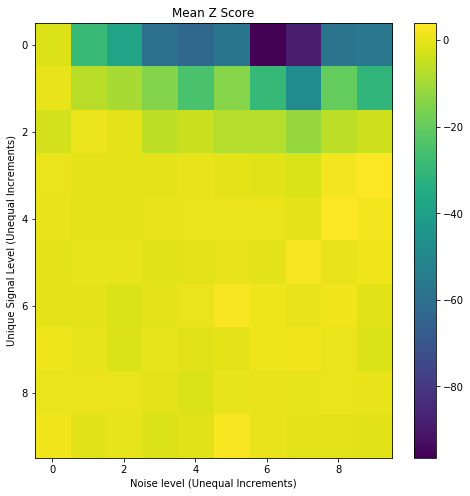

In [30]:

plt.figure(figsize=(8,8))
plt.imshow(array_1,aspect='auto')
plt.title('Mean Z Score')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


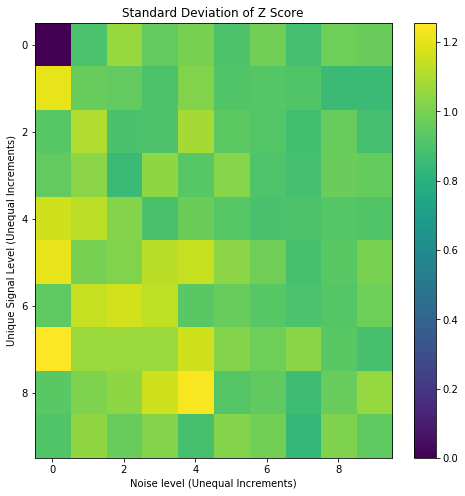

In [30]:

plt.figure(figsize=(8,8))
plt.imshow(array_2,aspect='auto')
plt.title('Standard Deviation of Z Score')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


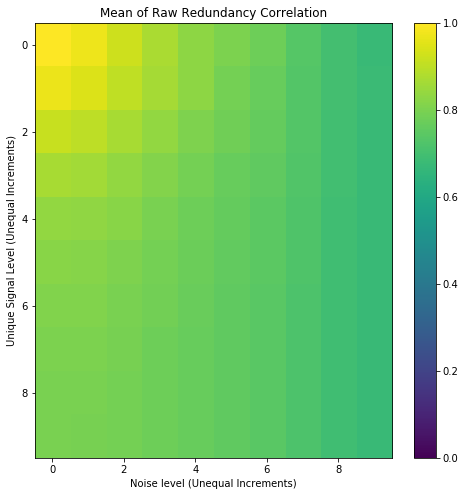

In [31]:

plt.figure(figsize=(8,8))
#plt.imshow(array_3,aspect='auto')
plt.imshow(array_3,aspect='auto',vmax = 1, vmin = 0)
plt.title('Mean of Raw Redundancy Correlation')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


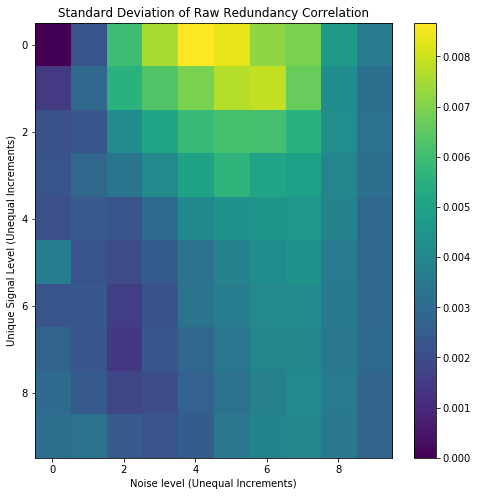

In [32]:

plt.figure(figsize=(8,8))
plt.imshow(array_4,aspect='auto')
plt.title('Standard Deviation of Raw Redundancy Correlation')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


In [33]:

slice_1 = []
slice_2 = []
slice_3 = []


for i in holder_array:
    
    slice_1.append(i[0][2])
    
    slice_2.append(i[4][2])
    
    slice_3.append(i[9][2])
    

In [34]:

err_1 = []
err_2 = []
err_3 = []

for i in holder_array:
    
    err_1.append(i[0][3])
    
    err_2.append(i[4][3])
    
    err_3.append(i[9][3])


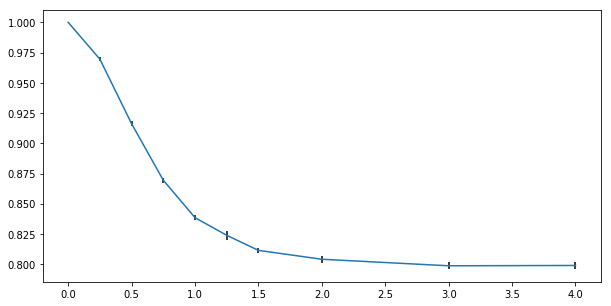

In [37]:

plt.figure(figsize = (10,5))
plt.errorbar(i_vals,slice_1,yerr=err_1,ecolor = 'k')

plt.show()


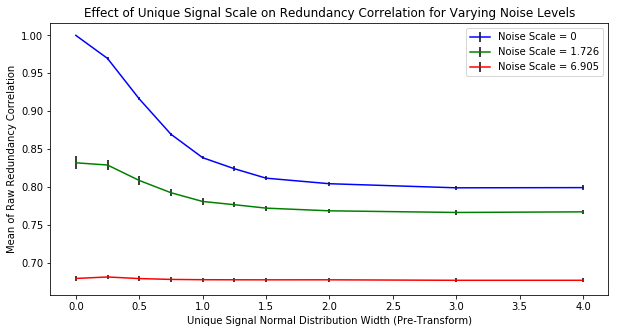

In [36]:

plt.figure(figsize = (10,5))
plt.errorbar(i_vals,slice_1,yerr=err_1,ecolor = 'k',c = 'b',label = 'Noise Scale = 0')
plt.errorbar(i_vals,slice_2,yerr=err_2,ecolor = 'k',c = 'g',label = 'Noise Scale = 1.726')
plt.errorbar(i_vals,slice_3,yerr=err_3,ecolor = 'k',c = 'r',label = 'Noise Scale = 6.905')
plt.xlabel('Unique Signal Normal Distribution Width (Pre-Transform)')
plt.ylabel('Mean of Raw Redundancy Correlation')
plt.legend()
plt.title('Effect of Unique Signal Scale on Redundancy Correlation for Varying Noise Levels')
plt.show()


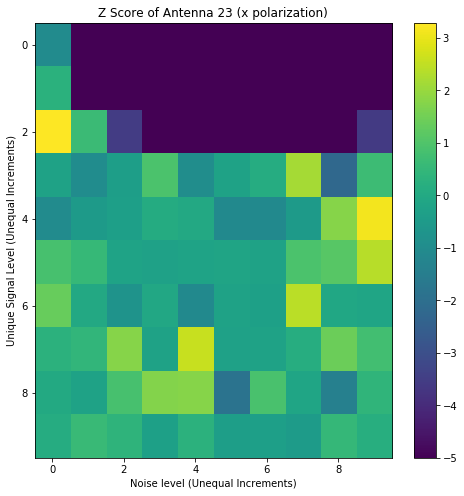

In [50]:

plt.figure(figsize=(8,8))
plt.imshow(array_1,aspect='auto',vmin = -5)
plt.title('Z Score of Antenna 23 (x polarization)')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


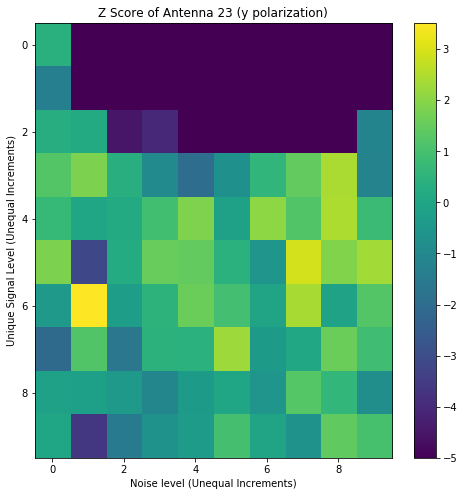

In [51]:

plt.figure(figsize=(8,8))
plt.imshow(array_2,aspect='auto',vmin = -5)
plt.title('Z Score of Antenna 23 (y polarization)')
plt.xlabel('Noise level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


In [52]:

avg_array = np.zeros((10,10))

for i in range(len(array_1)):
    
    for j in range(len(array_1[0])):
        
        avg_array[i,j] = (array_1[i][j]+array_2[i][j])/2.
 

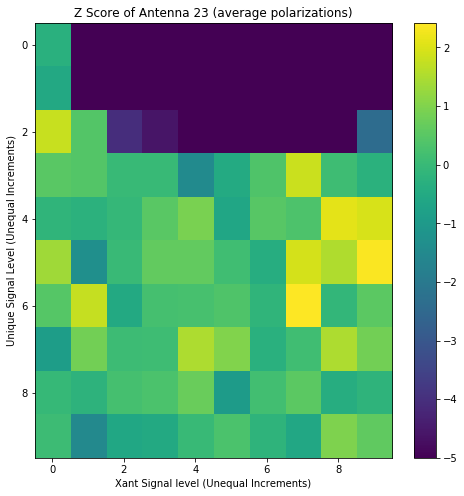

In [64]:

plt.figure(figsize=(8,8))
plt.imshow(avg_array,aspect='auto', vmin = -5)
plt.title('Z Score of Antenna 23 (average polarizations)')
plt.xlabel('Xant Signal level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


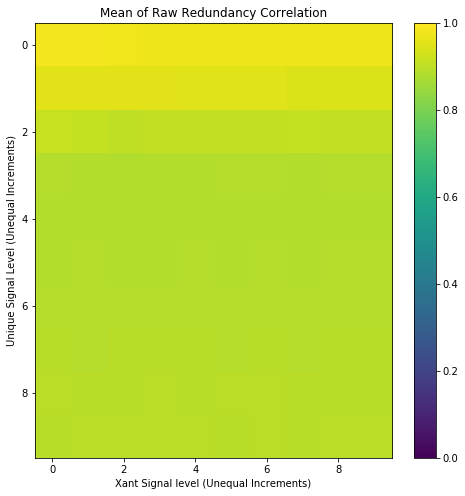

In [54]:

plt.figure(figsize=(8,8))
plt.imshow(array_3,aspect='auto',vmax = 1, vmin = 0)
plt.title('Mean of Raw Redundancy Correlation')
plt.xlabel('Xant Signal level (Unequal Increments)')
plt.ylabel('Unique Signal Level (Unequal Increments)')
plt.colorbar()
plt.show()


In [55]:

slice_0 = []
slice_1 = []
slice_2 = []
slice_3 = []
slice_4 = []
slice_5 = []


for i in range(len(holder_array)):
    
    slice_0.append(holder_array[0][i][0])
    slice_1.append(holder_array[1][i][0])
    slice_2.append(holder_array[2][i][0])
    slice_3.append(holder_array[3][i][0])
    slice_4.append(holder_array[4][i][0])
    slice_5.append(holder_array[5][i][0])
    

In [56]:

avg_0 = []
avg_1 = []
avg_2 = []
avg_3 = []
avg_4 = []
avg_5 = []


for i in range(len(avg_array)):
    
    avg_0.append(avg_array[0][i])
    avg_1.append(avg_array[1][i])
    avg_2.append(avg_array[2][i])
    avg_3.append(avg_array[3][i])
    avg_4.append(avg_array[4][i])
    avg_5.append(avg_array[5][i])

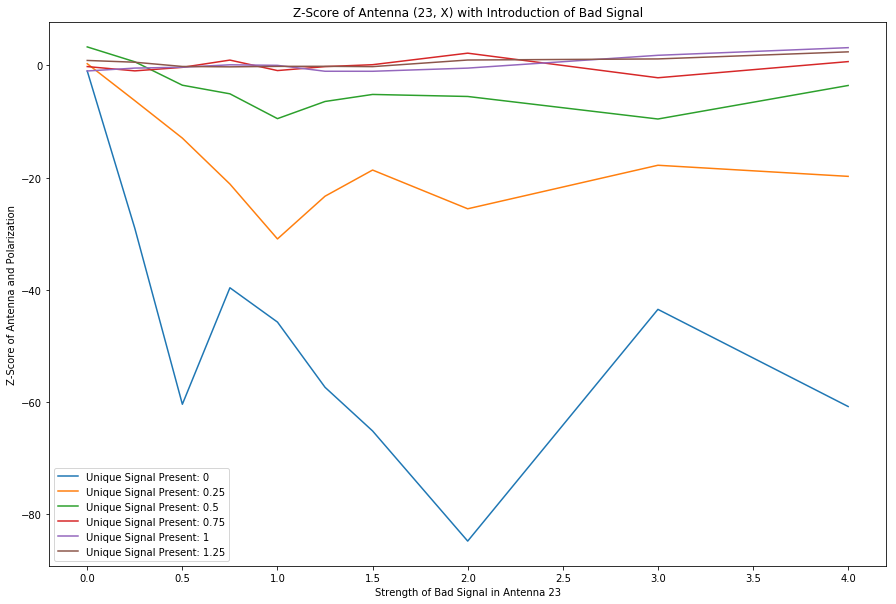

In [57]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,slice_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,slice_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,slice_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,slice_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,slice_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,slice_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal')
plt.legend()
plt.show()

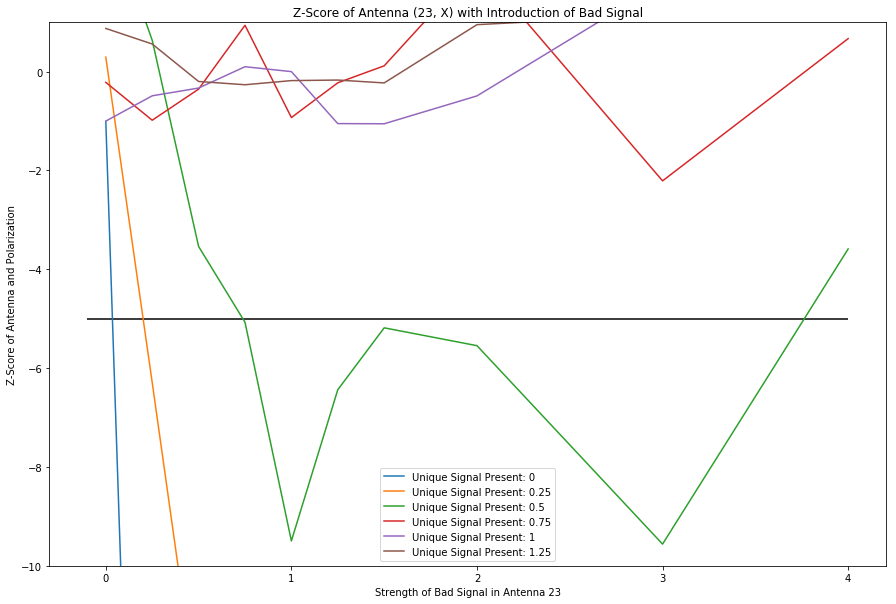

In [58]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,slice_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,slice_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,slice_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,slice_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,slice_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,slice_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna (23, X) with Introduction of Bad Signal')
plt.hlines(-5,-0.1,4)
plt.ylim((-10,1))
plt.legend()
plt.show()

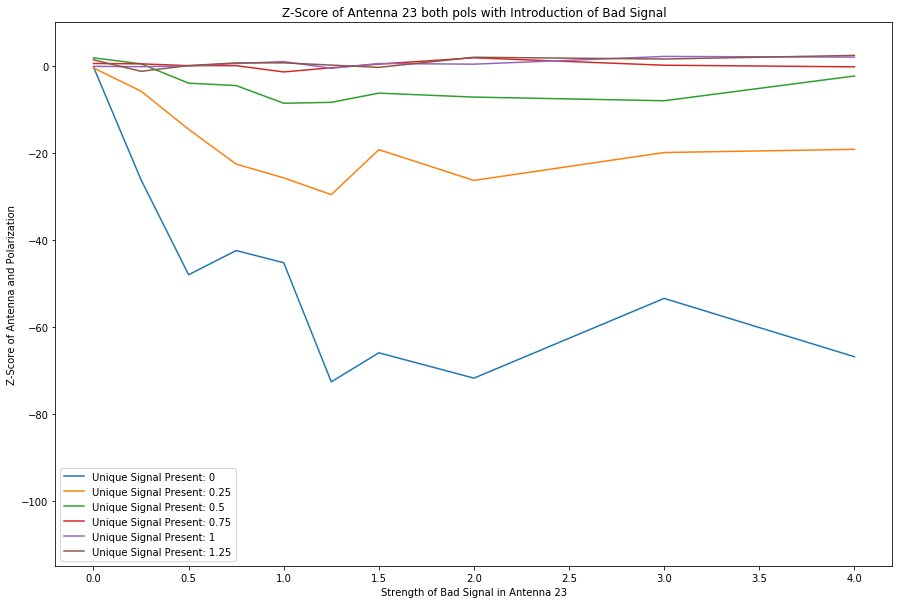

In [59]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,avg_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,avg_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,avg_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,avg_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,avg_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,avg_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna 23 both pols with Introduction of Bad Signal')
plt.ylim(-115,10)
plt.legend()
plt.show()

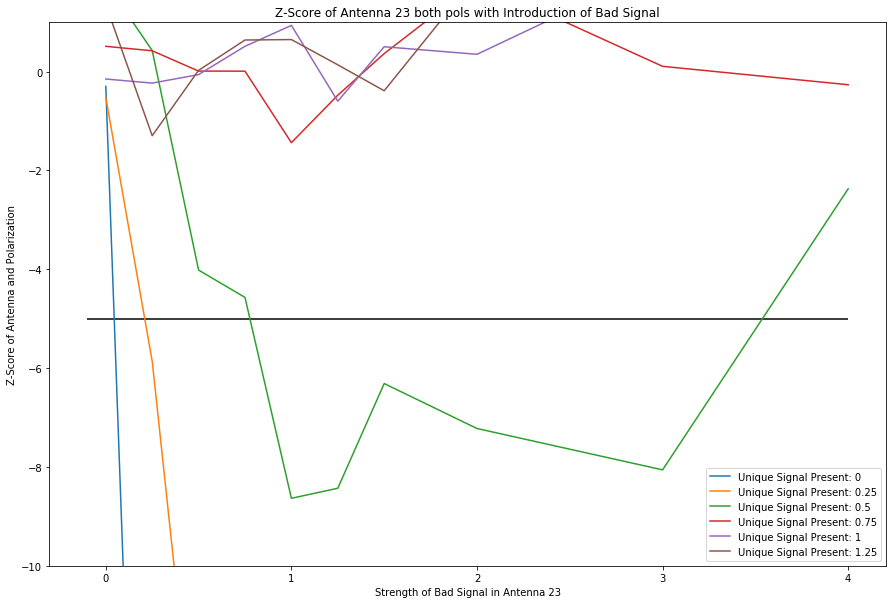

In [60]:

plt.figure(figsize = (15,10))
plt.plot(x_vals,avg_0, label = "Unique Signal Present: 0")
plt.plot(x_vals,avg_1, label = "Unique Signal Present: 0.25")
plt.plot(x_vals,avg_2, label = "Unique Signal Present: 0.5")
plt.plot(x_vals,avg_3, label = "Unique Signal Present: 0.75")
plt.plot(x_vals,avg_4, label = "Unique Signal Present: 1")
plt.plot(x_vals,avg_5, label = "Unique Signal Present: 1.25")
plt.xlabel('Strength of Bad Signal in Antenna 23')
plt.ylabel('Z-Score of Antenna and Polarization')
plt.title('Z-Score of Antenna 23 both pols with Introduction of Bad Signal')
plt.hlines(-5,-0.1,4)
plt.ylim((-10,1))
plt.legend()
plt.show()